# Integration of scRNA-seq data with substantial batch effects using sysVI

This tutorial shows how to integrate scRNA-seq datasets with substantial batch effects (here referred to as _systems_), such as cross-species, cross-technology (e.g. cells and nuclei), and primary tissue and _in vitro_ model system (e.g. organoid) datasets. In this tutorial, we use the sysVI model that combines VampPrior and latent cycle-consistency loss on top of a cVAE to improve integration.

For more details on this method please see our paper [Integrating single-cell RNA-seq datasets with substantial batch effects](https://doi.org/10.1101/2023.11.03.565463).

While sysVI is implemented in Python, users may decide to call it from R via the `reticulate` package as shown in this [scvi-tools tutorial](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/scvi_in_R.html) or to convert their data objects between R and Python with packages [`anndata2ri`](https://github.com/theislab/anndata2ri) and [`zellkonverter`](https://github.com/theislab/zellkonverter) to make use of sysVI directly in Python.


In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile

import matplotlib.pyplot as plt
import scanpy as sc

# Reproducibility
import scvi
from scvi.external import SysVI

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
Seed set to 0


Last run with scvi-tools version: 1.3.0


## Prepare data for integration

### Prepare features

In general, it is important that the feature characteristics match across systems, as this is key for successful integration. For example, if you used the model on scRNA-seq data it needs to be correctly preprocessed, as described below, and similarly, if you tested it on other data types, such as image features, good preprocessing is likewise vital. Furthermore, please keep in mind that the model assumes Gaussian noise distribution of features. 

For scRNA-seq data the integration should be performed on normalized and log-transformed data, with normalization being set to a fixed number of counts per cell. We recomend that data should be subsetted to HVGs before integration. In our paper we selected HVGs per system (e.g. species) with Scanpy function `pp.highly_variable_genes` using within-system batches as the `batch_key`, starting with genes present in all systems. Then, we took the intersection of HVGs across systems to obtain ~2000 shared HVGs. The here-used example data was already preprocessed accordingly and has normalized data in X. 

### Prepare covariates

For integration we must define covariates to be corrected for by the model. The `batch_key` covariate should represent the covariate capturing the substantial batch effects, also referred to as "system" in our publication. Besides system covariate, any other relatively weaker batch effects of a continuous or categorical nature can be corrected for as part of the standard conditioning within cVAE training. This can be for example samples within systems, denoted by obs column "batch" in the below example. 

If you have more than one type of system, such as species and technology, you can try to set the system to their combination. For example, if integrating cell and nuclei data from mouse and human the systems should be: mouse-nuclei, mouse-cell, human-nuclei, human-cell. This system grouping should be likewise used for data preprocessing, such as HVG selection. 

If the number of categories in additional categorical covariates is extensive, the one-hot encoding would lead to large memory usage. In this case, categorical covariates should be embedded by setting `embed_cat = True` during `Model` initialization, as explained below.

In [3]:
# Load data
# Save dir may be changed as desired
save_dir = tempfile.TemporaryDirectory()
adata_path = os.path.join(save_dir.name, "mouse-human_pancreas_subset10000.h5ad")
adata = sc.read(
    adata_path,
    backup_url="https://github.com/theislab/cross_system_integration/raw/main/tutorials/data/mouse-human_pancreas_subset10000.h5ad",
)
adata

  0%|          | 0.00/38.2M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 10000 × 1768
    obs: 'batch', 'mm_study', 'mm_sex', 'mm_age', 'mm_study_sample_design', 'mm_hc_gene_programs_parsed', 'mm_leiden_r1.5_parsed', 'cell_type_eval', 'system', 'hs_Sex', 'hs_Diabetes Status', 'leiden_system'
    var: 'gs_mm', 'gs_hs'
    obsm: 'X_pca_system'
    layers: 'counts'

In [4]:
# Setup adata for training
SysVI.setup_anndata(
    adata=adata,
    batch_key="system",
    categorical_covariate_keys=["batch"],
)

## Train the model

To embedd categorical covariates, the model can be initialized with `embed_categorical_covariates=True` as shown below. This will embed all categorical covariates, including `batch_key`.

```python
# Example showing how to turn on embedding of all categorical covariates
model = SysVI(
    adata=adata,
    embed_categorical_covariates=True,
)
```

We suggest that the model with the VampPrior and latent cycle-consistency is used, as shown below. However, if desired, the prior can be changed to standard normal distribution or the number of prior components for VampPrior can be modified during `Model` initialization. To disable cycle-consistency you can set the `z_distance_cycle_weight` to zero via `plan_kwargs` in `train`, which will then correspond to vanilla cVAE with the chosen prior.

```python
# Example showing how to adjust loss weights
model.train(
    plan_kwargs={
        "kl_weight": 1,
        "z_distance_cycle_weight": 0
        # Add additional parameters, such as number of epochs
    }
)
```

To increase batch correction you can increase cycle-consistency loss weight and to improve biological preservation you can decrease the KL loss weight or also cycle-consistency loss weight. In a few cases we observed the best integration performance with cycle-consistency loss weight as high as 50, although the range of 2-10 was usually preferred.

The number of epochs can be reduced when using a dataset with more cells. Please inspect the loss plots below to confirm that the number of epochs is sufficient for the loss to stabilize. 

Another thing to keep in mind is that model performance may vary depending on the used random seed, as reported in our paper. Thus, it may be beneficial to run a few (e.g. three) models with different random seeds and pick the best one. Random seed for `scvi-tools` can be set as shown below, before training the model.

```python
# Change the seed
scvi.settings.seed = 1

# Now initialise and train the model
model = SysVI(adata=adata)
model.train()
```

In [5]:
# Initialise the model
model = SysVI(adata=adata)
# Train
max_epochs = 200
model.train(
    max_epochs=max_epochs, check_val_every_n_epoch=1, plan_kwargs={"z_distance_cycle_weight": 5}
)

INFO     The model has been initialized                                                                            


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not h

Training:   0%|          | 0/200 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


### Inspect the losses to assess if the training was succesful

Training loss is plotted in blue and validation loss (held out random cells) in orange. The two losses will be similar due to the cells being randomly sampled into training/validation set without any stratification that would create truly distinct training/validation cell populations.

The top row shows the whole training history while the bottom row shows a zoom-in into the epochs at the end of the training.

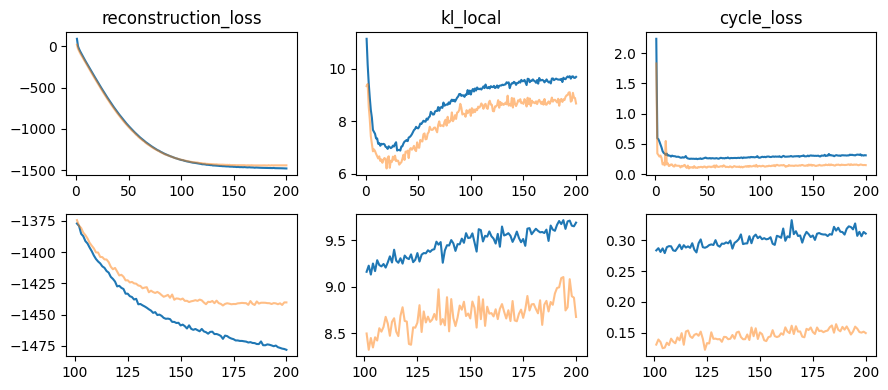

In [6]:
# Plot loses
# The plotting code below was specifically adapted to the above-specified model and its training
# If changing the model or training the plotting functions may need to be adapted accordingly

# Make detailed plot after N epochs
epochs_detail_plot = 100

# Losses to plot
losses = [
    "reconstruction_loss_train",
    "kl_local_train",
    "cycle_loss_train",
]
fig, axs = plt.subplots(2, len(losses), figsize=(len(losses) * 3, 4))
for ax_i, l_train in enumerate(losses):
    l_val = l_train.replace("_train", "_validation")
    l_name = l_train.replace("_train", "")
    # Change idx of epochs to start with 1
    l_val_values = model.trainer.logger.history[l_val].copy()
    l_val_values.index = l_val_values.index + 1
    l_train_values = model.trainer.logger.history[l_train].copy()
    l_train_values.index = l_train_values.index + 1
    for l_values, c, alpha, dp in [
        (l_train_values, "tab:blue", 1, epochs_detail_plot),
        (l_val_values, "tab:orange", 0.5, epochs_detail_plot),
    ]:
        axs[0, ax_i].plot(l_values.index, l_values.values.ravel(), c=c, alpha=alpha)
        axs[0, ax_i].set_title(l_name)
        axs[1, ax_i].plot(l_values.index[dp:], l_values.values.ravel()[dp:], c=c, alpha=alpha)

fig.tight_layout()

## Integrated embedding

Below we show how to obtain the integrated embedding after the model is trained and visually assess cell type preservation and system integration. For more detailed evaluation examples and integration metrics see our [paper](https://doi.org/10.1101/2023.11.03.565463).

In [7]:
# Get embedding - save it into X of new AnnData
embed = model.get_latent_representation(adata=adata)
embed = sc.AnnData(embed, obs=adata.obs)
# Make system categorical for plotting below
embed.obs["system"] = embed.obs["system"].map({0: "mouse", 1: "human"})

Plot the integrated embedding with system and cell type information to assess the integration quality.

In [8]:
# Compute UMAP
sc.pp.neighbors(embed, use_rep="X")
sc.tl.umap(embed)

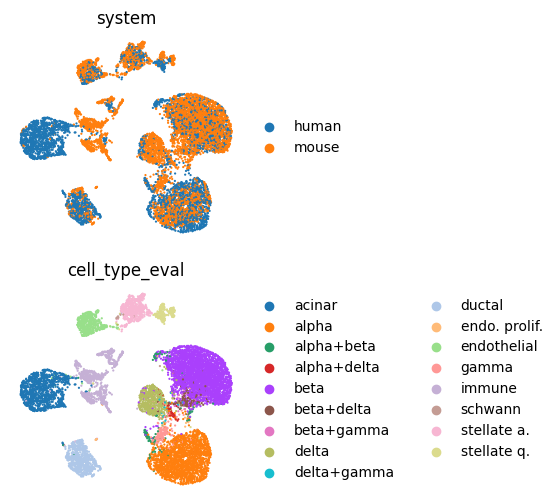

In [9]:
# Plot UMAP embedding

# Obs columns to color by
cols = ["system", "cell_type_eval"]

# One plot per obs column used for coloring
fig, axs = plt.subplots(len(cols), 1, figsize=(3, 3 * len(cols)))
for col, ax in zip(cols, axs, strict=False):
    sc.pl.embedding(
        embed,
        "X_umap",
        color=col,
        s=10,
        ax=ax,
        show=False,
        sort_order=False,
        frameon=False,
    )

To inspect cell type preservation and system integration in more detail we suggest plotting cell types separately per system.

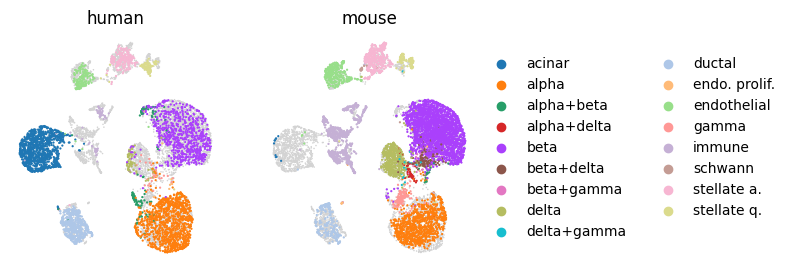

In [10]:
# Plot UMAP embedding per system
systems = sorted(embed.obs.system.unique())
ncols = len(systems)
# Plot systms side by side
fig, axs = plt.subplots(1, ncols, figsize=(3 * ncols, 3))
for i, system in enumerate(systems):
    ax = axs[i]
    # Plot all cells as background and on top cells from one system colored by cell type
    sc.pl.umap(embed, ax=ax, show=False, s=5, frameon=False)
    sc.pl.umap(
        embed[embed.obs.system == system, :],
        color="cell_type_eval",
        ax=ax,
        show=False,
        s=10,
        frameon=False,
        title=system,
    )
    # Keep legend only on the last plot (assuming this legend contains all categories)
    if i != ncols - 1:
        ax.get_legend().remove()

If some of the integrated datasets are missing cell type labels, they can be transferred with a KNN-based approach as shown in [this tutorial](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/hub/query_hlca_knn.html#loading-the-query-model-from-the-reference-files).